## Chapter 3 [Imaging](Ch3-Imaging.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Image Processing in the SEM


part of 

## [Analysis of Scanning Electron Microscope Data](_Analysis_of_Scanning_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with scanning electron microscopes
 



## First we import all relvant libraries

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook

# Multidimensional Image library
import scipy.ndimage as ndimage

# it is a good idea to show the version numbers at this point for archiving reasons.\n",
notebook_version = '2019.9.01'
print('notebook version: ',notebook_version)
    
%gui qt

Populating the interactive namespace from numpy and matplotlib
notebook version:  2019.9.01


### Load a SEM image:

As an example we will use an image in the **SEM_example_data** directory

<IPython.core.display.Javascript object>


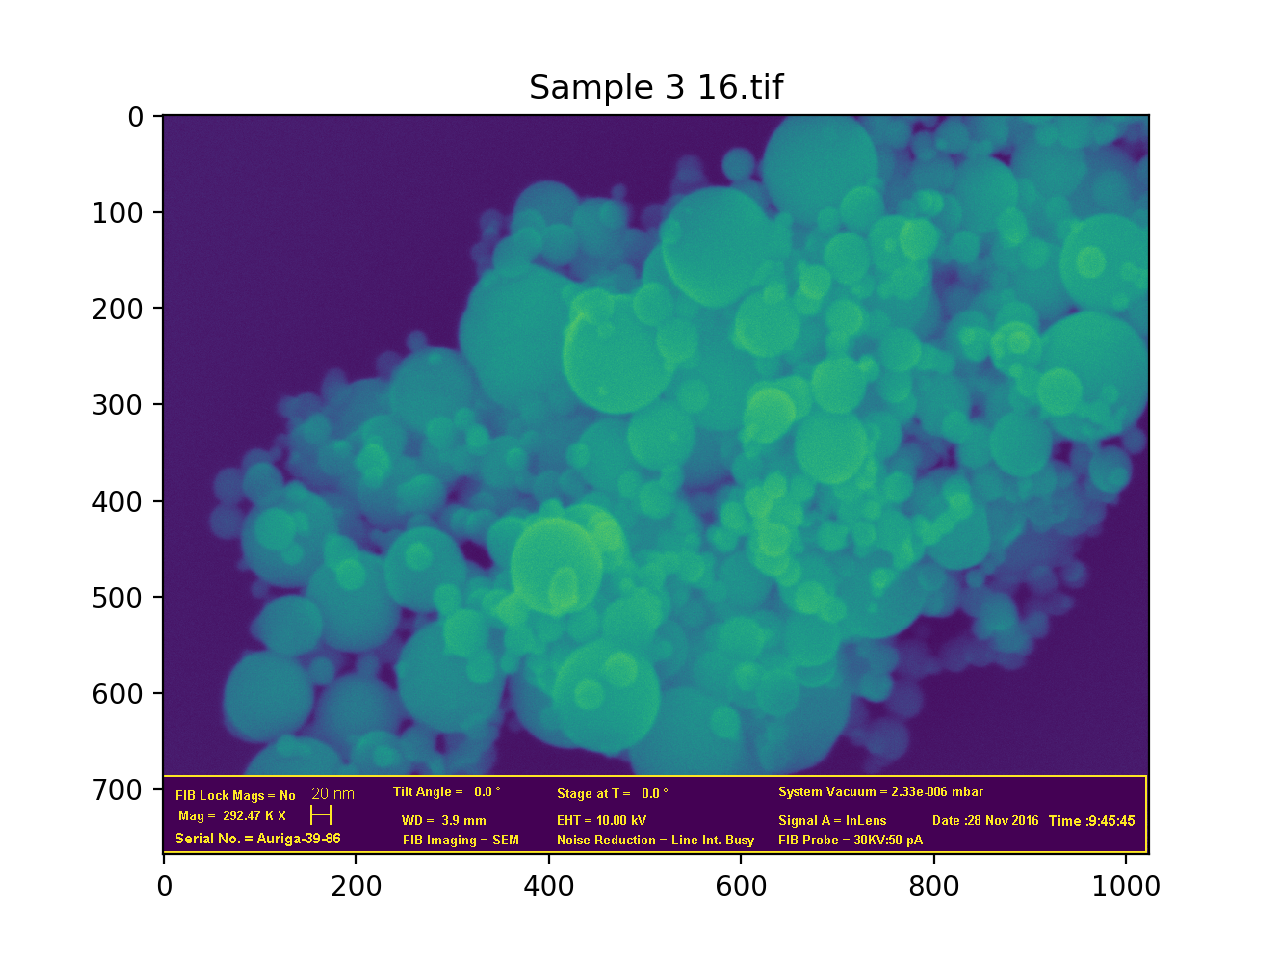

In [4]:
from PyQt5 import QtGui, QtWidgets

path = '' 
fname, file_filter = QtWidgets.QFileDialog.getOpenFileName(None, "Select a file...", path)

from PIL import Image 

im = Image.open(fname) 
data = numpy.array(im) 
plt.figure() 
plt.imshow(data)#, cmap = 'gray') 
plt.title(fname.split('/')[-1]);

An Electronic Image is  a matrix. 

![pixel.jpg](images_SEM/pixel.jpg)

In an SEM the origin is usually on the top left, and the fast scan direction is to the right (x-axis).

The contrast of an image is given by the standard deviation. The higher this standard deviation the more contrast is in the image.

Here we determine the minimum maximum and the contrast of the image we opened.


In [5]:
print(data[0:10,0:10])
print(data.shape)

print(f' minimum intensity is {data.min():.2f} counts and maximum intensity is {data.max():.2f}')
print(f'The image contrast is {np.std(data):.2f}')


[[17 22 24 20 25 22 21 20 23 23]
 [20 20 20 18 18 22 19 22 23 23]
 [20 24 22 20 22 22 17 19 20 18]
 [23 20 19 19 20 23 19 21 20 18]
 [20 21 21 18 21 21 16 21 20 20]
 [18 22 18 17 22 21 24 22 20 17]
 [19 19 20 22 27 20 17 22 19 22]
 [22 22 20 20 23 21 18 21 17 22]
 [20 20 21 23 21 23 20 21 23 21]
 [20 21 21 19 22 23 20 20 25 19]]
(768, 1024)
 minimum intensity is 0.00 counts and maximum intensity is 255.00
The image contrast is 59.51


## Histogram 

An intensity histogram is another good way to judge the quality of an image.

<IPython.core.display.Javascript object>


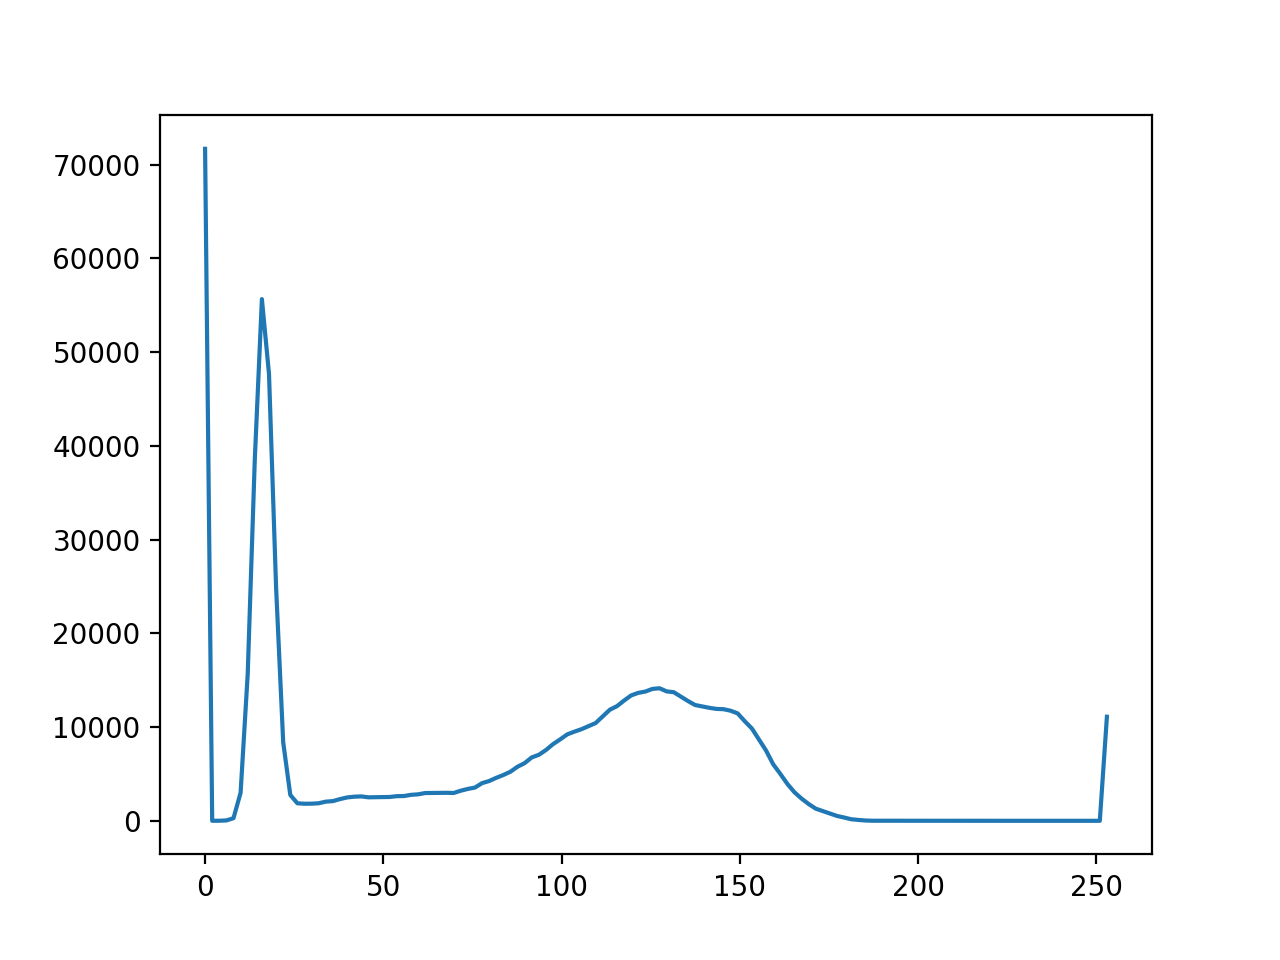

In [6]:
nbins = int(256/2)
hist_frequency, histo_intensities = np.histogram(data, bins=nbins)

plt.figure()
plt.plot(histo_intensities[:-1],hist_frequency,label='intensities')

The intensities in an image are important but for a 
meaningfull analysis we need additional information such as 
magnification and such. This information is stored as meta 
data in the image file and we need to access that.
   

## Install TIFF Image library

with this [tiffile](https://pypi.org/project/tifffile/) library we can read all the meta_data from a Zeiss SEM.

You need to install this only once!

In [7]:
!pip install tiffile

## Read Meta Data

Now we can read all the additional information needed from the metadata so that we can appropriately analyze the image.


In [8]:
import tifffile
tags = {}
tags['data'] = data
with tifffile.TiffFile(fname) as tif:
    tags['original_metadata'] = tif.sem_metadata


tags['spatial_scale_x'] = tags['spatial_scale_y'] = tags['original_metadata']['ap_image_pixel_size'][1] 
tags['spatial_units'] = tags['original_metadata']['ap_image_pixel_size'][2] 
tags['spatial_size_x'] = data.shape[1]
tags['spatial_size_y'] = data.shape[0]

tags['acceleration_voltage_V'] = tags['original_metadata']['ap_actualkv' ][1]*1000.0

###
# Optional, but it seems a good idea to read in the stage positions
###
for key in    tags['original_metadata']:
    if 'ap_stage_at' in key:
        if len(tags['original_metadata'][key])> 2:

            tags[tags['original_metadata'][key][0]] = tags['original_metadata'][key][1]
            tags[tags['original_metadata'][key][0]+'_units'] = tags['original_metadata'][key][2]
print('    meta data available directly in tags dictionary: ')            
for key in tags:
    if key not in ['data', 'original_metadata']:
        print(key, ': ', tags[key])

for key in    tags['original_metadata']:
    if 'CZ' in key:
        print(key)


    meta data available directly in tags dictionary: 
spatial_scale_x :  1.005
spatial_scale_y :  1.005
spatial_units :  nm
spatial_size_x :  1024
spatial_size_y :  768
acceleration_voltage_V :  10000.0
Stage at M :  5.0
Stage at M_units :  mm
Stage at Z :  47.757
Stage at Z_units :  mm
Stage at Y :  47.9784
Stage at Y_units :  mm
Stage at X :  68.3098
Stage at X_units :  mm
Stage at T :  0.0
Stage at T_units :  °
Stage at R :  329.4
Stage at R_units :  °


## Image Scale

In the age of electronic image acquisition, magnification is no longer a good measure (if it ever was).

There are two ways to express the scale of an image:
* field of view (FOV)
* length per pixel (in an SEM that would be nanometers per pixel)

There is a scale bar at the bottom of the image and we need to determine the **nanometers_per_pixel** of this image.

The assumption is that the pixel are square and so the FOV in x and y is then given by the image size and the pixel size.

So, zoom into the image to make the scale bar large and select the activated rectangular selection to the size of the scale bar.


<IPython.core.display.Javascript object>


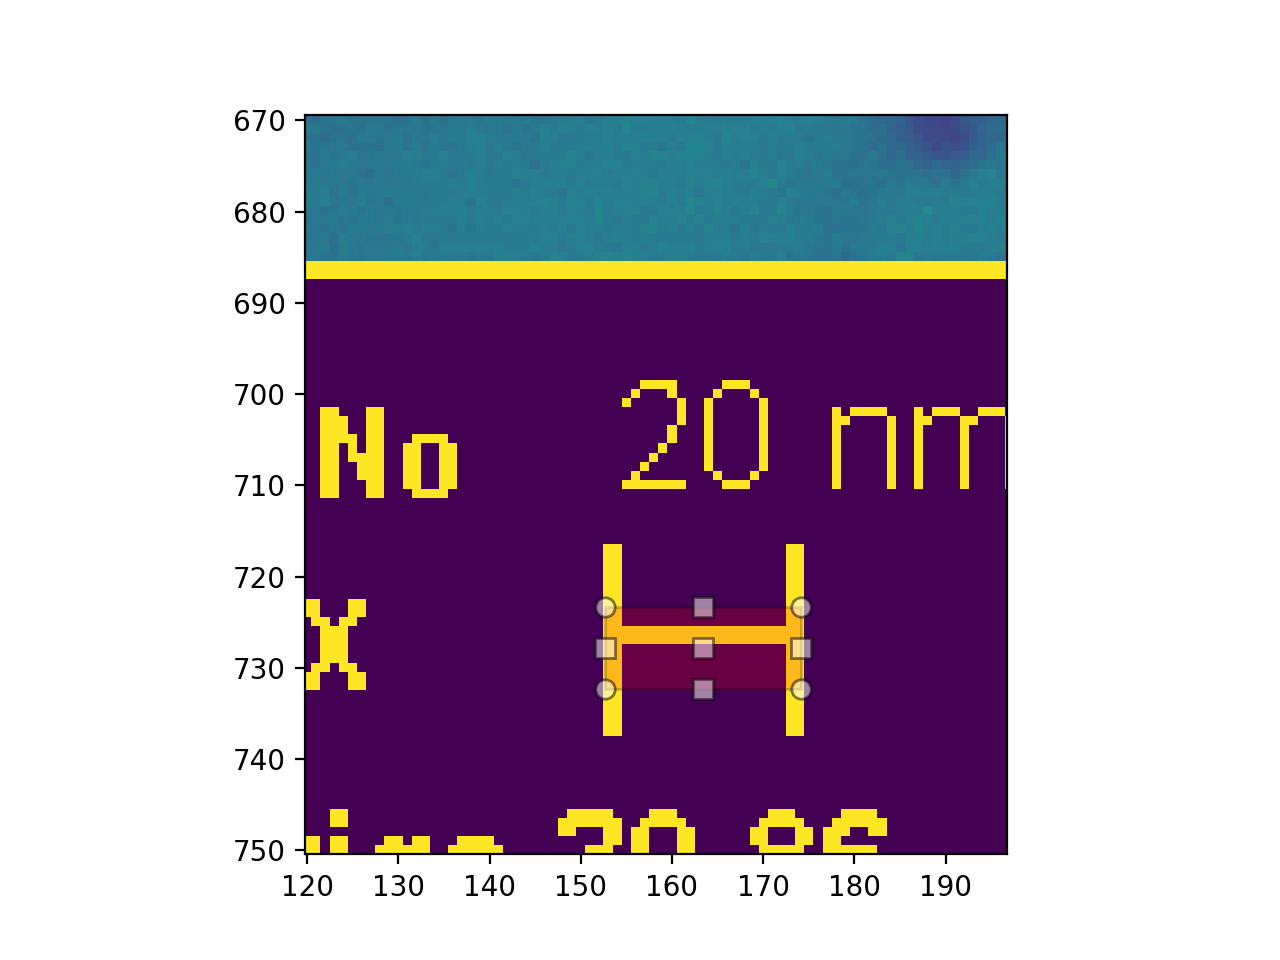

In [9]:
plt.figure()

plt.imshow(data)
import matplotlib.widgets as mwidgets

def onselect(vmin, vmax):
    print(vmin, vmax)

rectprops = dict(facecolor='blue', alpha=0.5)
span = mwidgets.RectangleSelector(plt.gca(), None,
                            drawtype='box', useblit=False, button=[1],
                            minspanx=5, minspany=5, spancoords='pixels',
                            interactive=True)

In [10]:
rectangle_width= span.extents[1]-span.extents[0]
scale_bar_width = 20.0 # in nm
print(f'The width of scale bar is {rectangle_width:.1f} pixels which is {scale_bar_width:.0f} nm')
nm_per_pixel = scale_bar_width/rectangle_width

print(f'That is {nm_per_pixel:.3f} nm/pixel')
print(f"The real pixel size is: {tags['spatial_scale_x']} nm, so you made an error of {(tags['spatial_scale_x']-nm_per_pixel)/tags['spatial_scale_x']*100:.1f} % ")


The width of scale bar is 21.5 pixels which is 20 nm
That is 0.931 nm/pixel
The real pixel size is: 1.005 nm, so you made an error of 7.4 % 


## Line Profile

In [11]:
line_number = 312
width = 2
line_number = 224
x = np.linspace(0,tags['spatial_size_x']-1,tags['spatial_size_x'])*tags['spatial_scale_x']
plt.figure()
plt.plot(x,data[line_number,:])
plt.ylabel('intensity [a.u]')
plt.xlabel('distance [nm]');
extent = [0,tags['spatial_scale_x']*tags['spatial_size_x'],tags['spatial_scale_y']*tags['spatial_size_y'],0]
plt.figure()
plt.imshow(data, extent = extent, origin = 'upper')
plt.plot(x,(data[line_number,:]*-1+line_number*tags['spatial_scale_y']), color='red')

plt.xlabel('distance [nm]');
line_number = int(line_number*tags['spatial_scale_y']) # now in image scale coordinates
plt.plot([0,tags['spatial_scale_x']*tags['spatial_size_x']],[line_number,line_number], color = 'red');
   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Image Resolution

The resolution in an image can be estimated by the raise of the intensity at a sharp feature. Here, we assume an atomically sharp edge that is smeared out (convoluted) with the electron beam shape.

In the line profile above, zoom in and see what your estimate of the resolution is.

There are several problems with this approach, here are the two most important ones:
* generation of secondary electrons at edges 
* no sharp edge exists


## Random Line Profile

Please be aware that non vertical or horizontal lines require some interpolation to display an intensity profile.

Still this is an important tool in the analysis of features in your image.
 
  

<IPython.core.display.Javascript object>


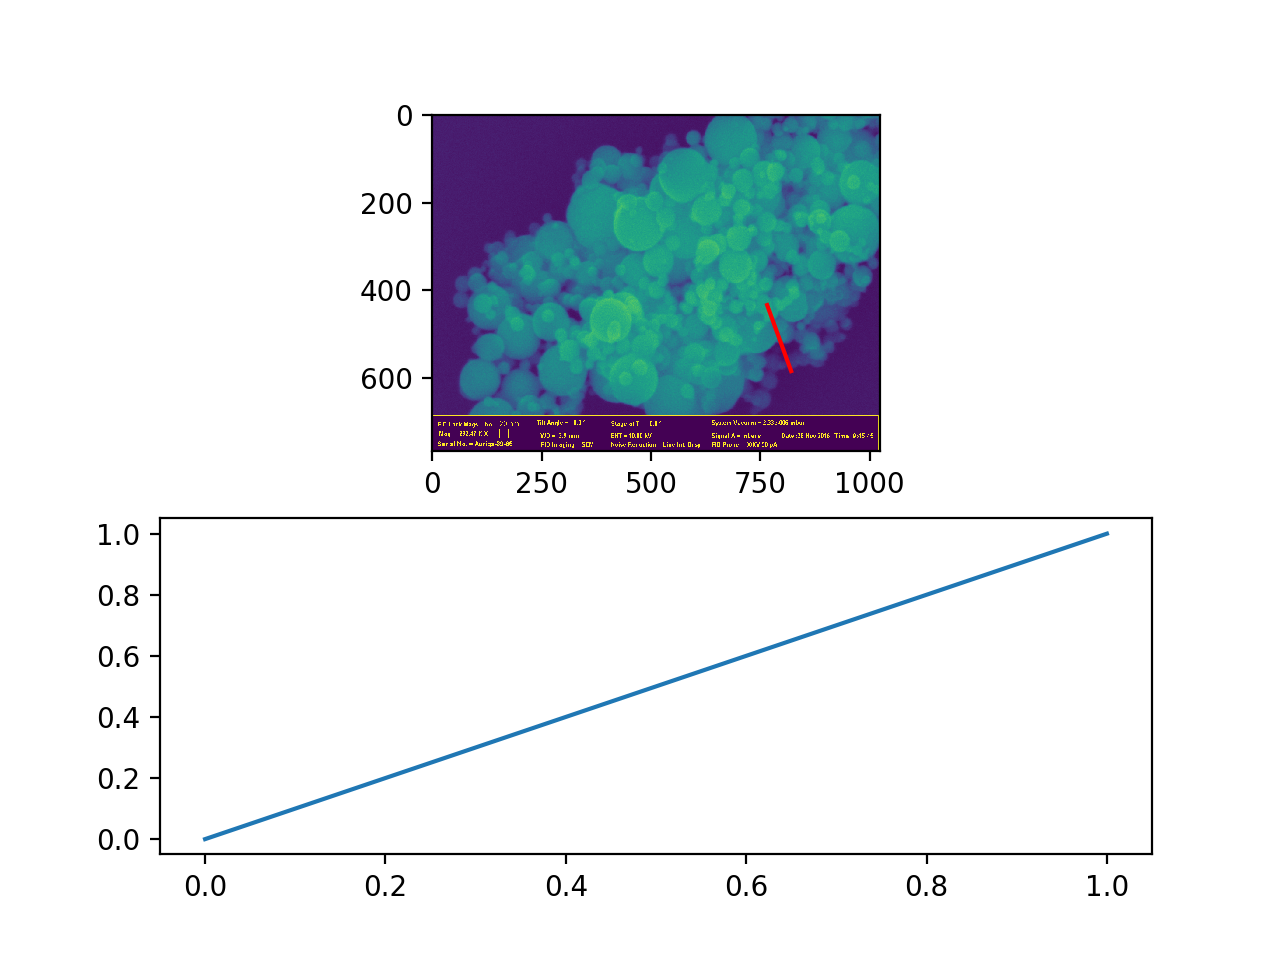

In [26]:
class LineProfile:
    global zi
    def __init__(self, axes,data, nm_per_pixel = 1.):
        self.data = data
        self.axes = axes
        axes[0].imshow(data)
        self.line,  = axes[0].plot([0], [0], color ='red')
        self.xs = list(self.line.get_xdata())
        self.ys = list(self.line.get_ydata())
        self.cid = self.line.figure.canvas.mpl_connect('button_press_event', self.click)
        axes[1].plot([0,1],[0,1])
             
    def click(self, event):
        print('click', event)
        if event.inaxes!=self.line.axes: return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.xs = self.xs[-2:]
        self.ys = self.ys[-2:]
        
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()
        
        num = 1000
        x, y = np.linspace(self.xs[0], self.xs[1], num), np.linspace(self.ys[0], self.ys[1], num)
        
        # Extract the values along the line, using cubic interpolation
        zi = scipy.ndimage.map_coordinates(self.data.T, np.vstack((x,y)))
        #length = np.linalg.norm([linebuilder.xs[0]-linebuilder.xs[1],linebuilder.ys[0]-linebuilder.ys[1]])
        x = np.linspace(0,num-1,num)/1000#*length*nm_per_pixel
        self.zi = zi
        self.axes[1].clear()
        self.axes[1].plot(x,zi)
        #self.line.figure.canvas.draw()
        
#-- Plot...
fig, axes = plt.subplots(nrows=2)
linebuilder = LineProfile(axes, data, nm_per_pixel)

## Fourier Transform of Image

<IPython.core.display.Javascript object>


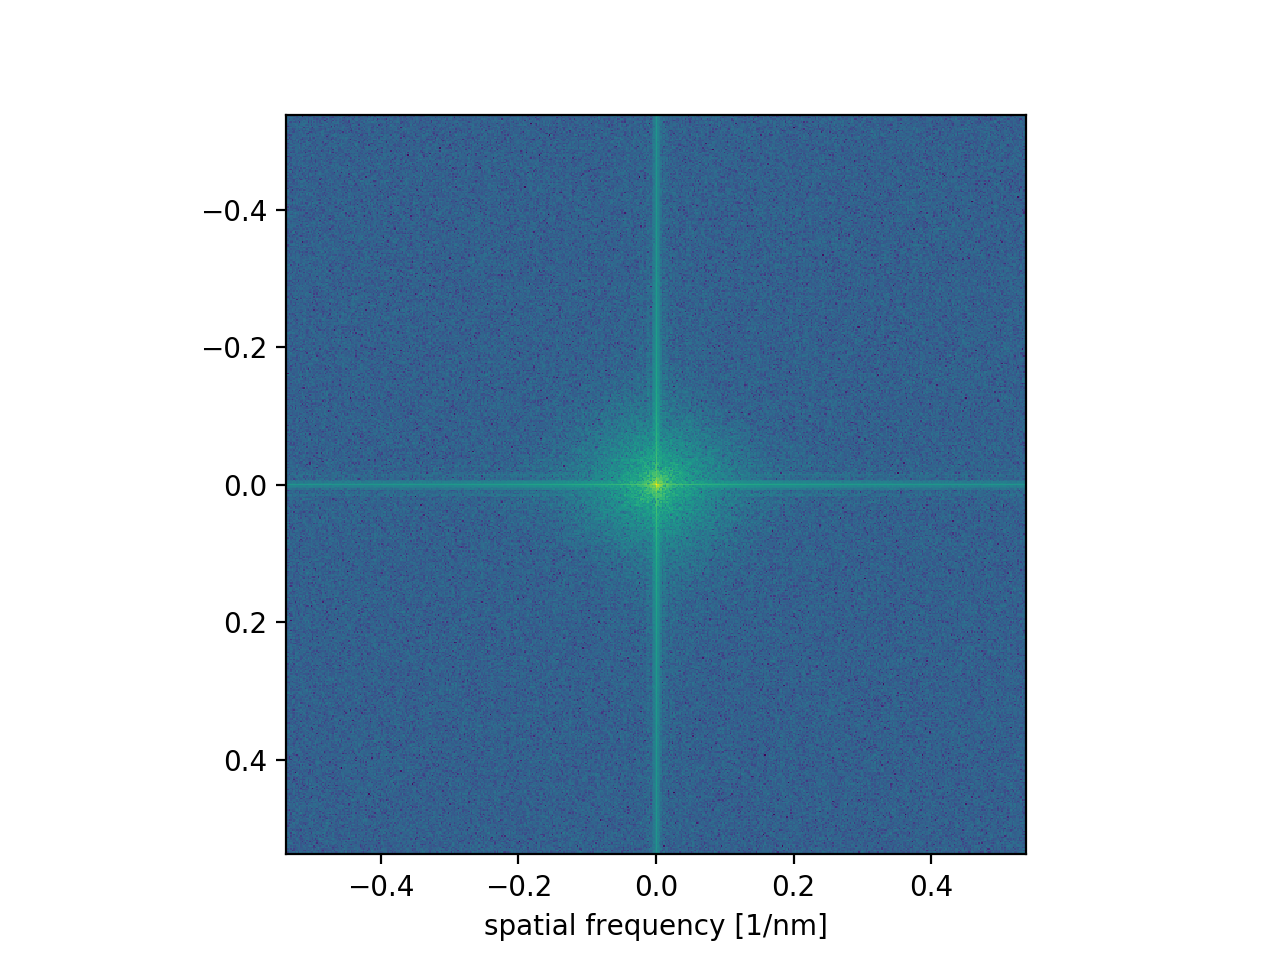

In [12]:
size_x = size_y = 512

image = data[0:size_x,0:size_y]- data[0:size_x,0:size_y].min()
fft_mag = (np.abs((np.fft.fftshift(np.fft.fft2(image)))))

FOV_x = size_x * nm_per_pixel
FOV_y = size_y * nm_per_pixel

## pixel_size in recipical space
rec_scale_x = 1/FOV_x  
rec_scale_y = 1/FOV_y 

## Field of View (FOV) in recipical space please note: rec_FOV_x = 1/(scaleX*2)
rec_FOV_x = rec_scale_x * size_x /2.
rec_FOV_y = rec_scale_y * size_y /2.

## Field ofView (FOV) in recipical space
rec_extend = (-rec_FOV_x,rec_FOV_x,rec_FOV_y,-rec_FOV_y)

fig = plt.figure()
plt.imshow(np.log(1e1+fft_mag).T, extent=rec_extend, origin = 'upper'); 
plt.xlabel('spatial frequency [1/nm]');

# Image Resolution 2

In [13]:
radius_of_circle_of_information = 0.117
print(f'resolution = {1/radius_of_circle_of_information:.2f} nm' )

resolution = 8.55 nm


## Fourier Filtering

We mask the Fourier transformed image so that only the selected information can pass through.

The information is in the center of the Fourier transformed image, the rest is noise.

Please modify the radius of the mask of  the **low-pass** area in the code below and notice the effects on the Fourier filtered image.

<IPython.core.display.Javascript object>


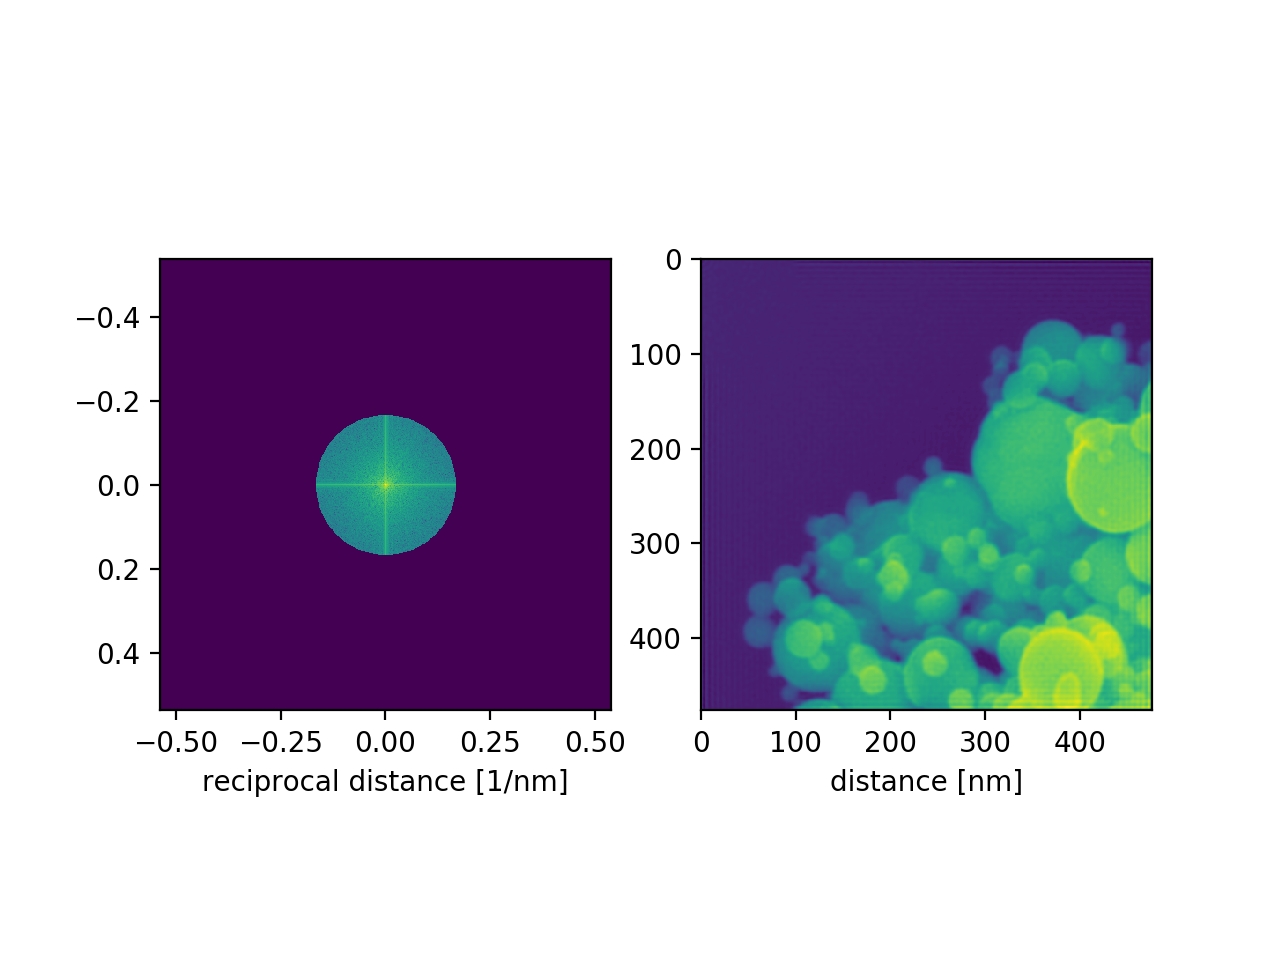

In [14]:
# Input 
low_pass = 1/6 # in 1/nm diameter of mask for low pass filter


#prepare mask
pixels = (np.linspace(0,image.shape[0]-1,image.shape[0])-image.shape[0]/2)* rec_scale_x

x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(image.shape)

# mask reflections

mask = x**2+y**2 < low_pass**2 

plt.figure()
ax1 = plt.subplot(1,2,1)
#ax1.imshow(mask)
fft_filtered = np.fft.fftshift(np.fft.fft2(image))*mask.T
ax1.imshow(np.log(1+np.abs(fft_filtered)).real,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
ax2 = plt.subplot(1,2,2)
filtered = np.fft.ifft2(np.fft.fftshift(fft_filtered))

real_extent = (0,FOV_x,FOV_y,0)
    
ax2.imshow(filtered.real,extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');

## Filtering and Features in Images

There is a whole zoo of images processing techniques that can now be used without any further efforts.

Please look at this [web page](https://scikit-image.org/docs/stable/auto_examples/edges/plot_contours.html#sphx-glr-auto-examples-edges-plot-contours-py)  at [scikit-images](https://scikit-image.org/) from which I copied the code below."


<IPython.core.display.Javascript object>


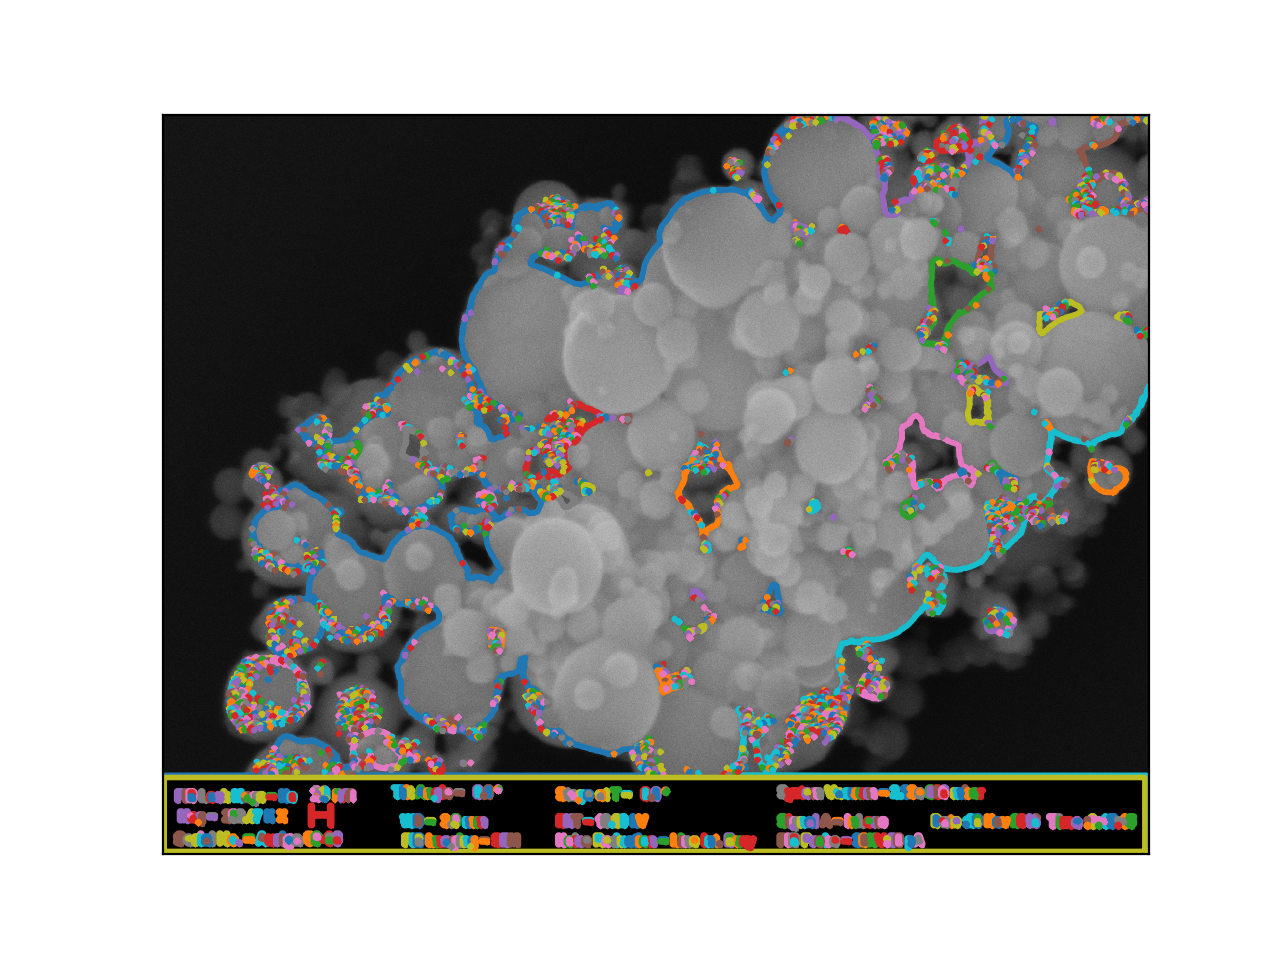

[]

In [15]:
from skimage import measure

# Find contours at a constant value of 0.8
contours = measure.find_contours(data, 100)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(data, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([]);


## Conclusion:

Fourier Transform is used to evaluate image quality and 
Resolution.


Fourier Filtering is used to eliminate high frequency noise.



## Back: [Image Formation](Ch3-Image_Formation_SEM.ipynb)
## Next: [Introduction to X-Ray](CH4-Introduction_X_Rays.ipynb)
## List of Content: [Front](_Analysis_of_Scanning_Electron_Microscope_Data.ipynb#Content)